<a href="https://colab.research.google.com/github/mdh266/TextClassificationApp/blob/feature%2Fkeras/NLP_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# !pip install gcsfs

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow as tf


In [8]:

from sklearn.preprocessing import LabelEncoder, label_binarize
train_df = pd.read_json("gs://harmon-arxiv/train_abstracts.json")
test_df  = pd.read_json("gs://harmon-arxiv/test_abstracts.json")

# train_df = train_df.query("category != 'ro'")
# test_df  = test_df.query("category != 'ro'")

labeler      = LabelEncoder()
train_df = train_df.assign(target=labeler.fit_transform(train_df["category"]))
test_df  = test_df.assign(target=labeler.fit_transform(test_df["category"]))

train_df.head()

,category,text,target
0,ai,Because of their occasional need to return to ...,0
1,ai,Market price systems constitute a well-underst...,0
2,ai,We describe an extensive study of search in GS...,0
3,ai,As real logic programmers normally use cut (!)...,0
4,ai,To support the goal of allowing users to recor...,0


In [9]:
from sklearn.utils import shuffle

train_df = shuffle(train_df)
test_df = shuffle(test_df)

In [10]:
train_df.head()

,category,text,target
1652,ml,"Prediction is a complex notion, and different ...",2
1996,ml,Random Forest (RF) is a powerful supervised le...,2
3966,cv,"In this paper, we propose a novel method for i...",1
4174,cv,In this paper we are proposing the use of Kani...,1
166,ai,A reported weakness of C4.5 in domains with co...,0


In [11]:
# classes = [0,1,2,3]
classes   = np.sort(train_df["target"].unique())

# relabel the test set
y_train = label_binarize(train_df["target"],
                         classes=classes)

y_test = label_binarize(test_df["target"], 
                        classes=classes)

In [13]:
max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
    # standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(train_df["text"].to_numpy())

In [14]:
model = Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string, name='text'),
            vectorize_layer,
            layers.Embedding(max_features, embedding_dim),
            layers.Dropout(0.5),

            # # Conv1D + global max pooling
            layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            layers.GlobalMaxPooling1D(),

            # # We add a vanilla hidden layer:
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),

            layers.Dense(4, activation="softmax")#, name="predictions")
])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560000   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 165, 128)          114816    
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                         

In [16]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy",tf.keras.metrics.AUC(name='prc', curve='PR')])

In [ ]:
epochs = 5

# Fit the model using the train and test datasets.
model.fit(train_df["text"], y_train, epochs=epochs, batch_size=128, validation_split=0.2)

Epoch 1/5
61/61 [==============================] - 25s 371ms/step - loss: 0.0386 - accuracy: 0.9886 - prc: 0.9982 - val_loss: 0.8279 - val_accuracy: 0.8285 - val_prc: 0.8715
Epoch 2/5
61/61 [==============================] - 21s 350ms/step - loss: 0.0141 - accuracy: 0.9959 - prc: 0.9999 - val_loss: 0.8971 - val_accuracy: 0.8264 - val_prc: 0.8631
Epoch 3/5
61/61 [==============================] - 21s 350ms/step - loss: 0.0119 - accuracy: 0.9959 - prc: 0.9999 - val_loss: 1.0564 - val_accuracy: 0.8275 - val_prc: 0.8470
Epoch 4/5
61/61 [==============================] - 25s 408ms/step - loss: 0.0060 - accuracy: 0.9977 - prc: 1.0000 - val_loss: 1.0598 - val_accuracy: 0.8316 - val_prc: 0.8492
Epoch 5/5
61/61 [==============================] - 28s 465ms/step - loss: 0.0060 - accuracy: 0.9979 - prc: 1.0000 - val_loss: 1.0531 - val_accuracy: 0.8326 - val_prc: 0.8547


In [ ]:
model.evaluate(test_df["text"], y_test)

50/50 [==============================] - 3s 61ms/step - loss: 1.1917 - accuracy: 0.7924 - prc: 0.8225


[1.1917134523391724, 0.7923809289932251, 0.8224775791168213]

In [21]:
val_cts = train_df["target"].value_counts().to_dict()

In [22]:
val_cts

{0: 1530, 1: 1530, 2: 1530, 3: 250}

In [23]:
weights = {0: 1, 1: 1, 2: 1, 3: 1503//250}

In [24]:
weights

{0: 1, 1: 1, 2: 1, 3: 6}

In [32]:
epochs = 25

model = Sequential([
            tf.keras.Input(shape=(1,), dtype=tf.string, name='text'),
            vectorize_layer,
            layers.Embedding(max_features, embedding_dim),
            layers.Dropout(0.5),

            # # Conv1D + global max pooling
            layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            layers.GlobalMaxPooling1D(),

            # # We add a vanilla hidden layer:
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),

            layers.Dense(4, activation="softmax")
])


model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy",tf.keras.metrics.AUC(name='prc', curve='PR')])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
# Fit the model using the train and test datasets.
weighted_history = model.fit(train_df["text"], 
                              y_train, 
                              epochs=epochs, 
                              batch_size=32, 
                              class_weight=weights, 
                              validation_split=0.2,
                              callbacks=[early_stopping_cb])

Epoch 1/25
121/121 [==============================] - 25s 201ms/step - loss: 1.7592 - accuracy: 0.2603 - prc: 0.2548 - val_loss: 1.3808 - val_accuracy: 0.3337 - val_prc: 0.3334
Epoch 2/25
121/121 [==============================] - 23s 192ms/step - loss: 1.5994 - accuracy: 0.3789 - prc: 0.4226 - val_loss: 0.7258 - val_accuracy: 0.7624 - val_prc: 0.8095
Epoch 3/25
121/121 [==============================] - 29s 236ms/step - loss: 0.6112 - accuracy: 0.8156 - prc: 0.8890 - val_loss: 0.3854 - val_accuracy: 0.8667 - val_prc: 0.9321
Epoch 4/25
121/121 [==============================] - 24s 198ms/step - loss: 0.2133 - accuracy: 0.9360 - prc: 0.9785 - val_loss: 0.3958 - val_accuracy: 0.8781 - val_prc: 0.9331
Epoch 5/25
121/121 [==============================] - 23s 191ms/step - loss: 0.0800 - accuracy: 0.9786 - prc: 0.9952 - val_loss: 0.4804 - val_accuracy: 0.8729 - val_prc: 0.9230
Epoch 6/25
121/121 [==============================] - 25s 204ms/step - loss: 0.0348 - accuracy: 0.9894 - prc: 0.999

In [38]:
weighted_history_df = pd.DataFrame(weighted_history.history)

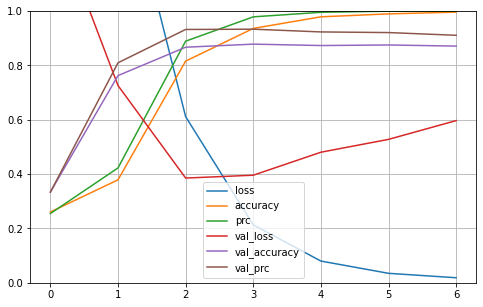

In [43]:
weighted_history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()